# Data

### Download data

In [1]:
!wget 'https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar'

--2023-02-08 20:22:20--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar’

wiki_crop.tar       100%[===================>] 773.73M  18.9MB/s    in 43s     

2023-02-08 20:23:04 (17.9 MB/s) - ‘wiki_crop.tar’ saved [811315200/811315200]



### Unzip

In [2]:
import tarfile
my_tar = tarfile.open('wiki_crop.tar')
my_tar.extractall('./')
my_tar.close()

### Load meta data

In [3]:
from pathlib import Path
meta_data_path = Path('wiki_crop/wiki.mat')

In [4]:
from scipy.io import loadmat

meta_data = loadmat(meta_data_path)

### Create CSV

In [5]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import datetime as date
from dateutil.relativedelta import relativedelta

cols = ['age', 'gender', 'path', 'face_score1', 'face_score2']

wiki_mat = 'wiki_crop/wiki.mat'

wiki_data = loadmat(wiki_mat)

del wiki_mat

wiki = wiki_data['wiki']

wiki_photo_taken = wiki[0][0][1][0]
wiki_full_path = wiki[0][0][2][0]
wiki_gender = wiki[0][0][3][0]
wiki_face_score1 = wiki[0][0][6][0]
wiki_face_score2 = wiki[0][0][7][0]

wiki_path = []

for path in wiki_full_path:
    wiki_path.append('wiki_crop/' + path[0])

wiki_genders = []

for n in range(len(wiki_gender)):
    if wiki_gender[n] == 1:
        wiki_genders.append('male')
    else:
        wiki_genders.append('female')

wiki_dob = []

for file in wiki_path:
    wiki_dob.append(file.split('_')[2])

wiki_age = []

for i in range(len(wiki_dob)):
    try:
        d1 = date.datetime.strptime(wiki_dob[i][0:10], '%Y-%m-%d')
        d2 = date.datetime.strptime(str(wiki_photo_taken[i]), '%Y')
        rdelta = relativedelta(d2, d1)
        diff = rdelta.years
    except Exception as ex:
        print(ex)
        diff = -1
    wiki_age.append(diff)

final_wiki = np.vstack((wiki_age, wiki_genders, wiki_path, wiki_face_score1, wiki_face_score2)).T

final_wiki_df = pd.DataFrame(final_wiki)

final_wiki_df.columns = cols

meta = final_wiki_df

meta = meta[meta['face_score1'] != '-inf']
meta = meta[meta['face_score2'] == 'nan']

meta = meta.drop(['face_score1', 'face_score2'], axis=1)

meta = meta.sample(frac=1)

meta.to_csv('meta.csv', index=False)

time data '829-09-08' does not match format '%Y-%m-%d'
time data '1823-12-00' does not match format '%Y-%m-%d'
time data '1953-10-00' does not match format '%Y-%m-%d'
time data '1984-15-03' does not match format '%Y-%m-%d'
time data '1963-02-00' does not match format '%Y-%m-%d'
time data '1977-04-00' does not match format '%Y-%m-%d'
time data '1946-05-00' does not match format '%Y-%m-%d'
time data '647-05-15' does not match format '%Y-%m-%d'
time data '11-03-00' does not match format '%Y-%m-%d'
time data '1980-05-00' does not match format '%Y-%m-%d'
time data '1960-02-00' does not match format '%Y-%m-%d'
time data '1975-03-00' does not match format '%Y-%m-%d'
time data '1952-11-00' does not match format '%Y-%m-%d'
time data '1974-04-00' does not match format '%Y-%m-%d'
time data '1996-25-05' does not match format '%Y-%m-%d'
time data '1914-02-00' does not match format '%Y-%m-%d'


In [6]:
import pandas as pd

meta_df = pd.read_csv('meta.csv')
meta_df

,age,gender,path
0,38,male,wiki_crop/71/2275071_1955-04-23_1994.jpg
1,38,female,wiki_crop/86/7886_1975-02-22_2014.jpg
2,57,male,wiki_crop/26/16611126_1892-01-10_1950.jpg
3,24,female,wiki_crop/94/2645394_1985-12-29_2010.jpg
4,52,male,wiki_crop/27/17107027_1918-08-24_1971.jpg
...,...,...,...
40211,32,male,wiki_crop/18/8951218_1978-05-01_2011.jpg
40212,51,male,wiki_crop/10/2560010_1960-12-26_2012.jpg
40213,17,male,wiki_crop/90/40169590_1996-02-11_2014.jpg
40214,63,female,wiki_crop/00/3243400_1943-06-04_2007.jpg


### Create dataset

In [7]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split

meta = pd.read_csv('meta.csv')

meta = meta.drop(['gender'], axis=1)

meta = meta[meta['age'] >= 0]
meta = meta[meta['age'] <= 101]

meta = meta.values

D_train, D_test = train_test_split(meta, test_size=0.1, random_state=42)

dataset_path = 'dataset/'

# Making the directory structure
for i in range(102):
    output_dir_train = dataset_path + '/train/' + str(i)
    output_dir_test = dataset_path + '/test/' + str(i)

    if not os.path.exists(output_dir_train):
        os.makedirs(output_dir_train)
        
    if not os.path.exists(output_dir_test):
        os.makedirs(output_dir_test)

# Finally making the training and testing set
counter = 0
for image in D_train:
    img = cv2.imread(image[1], 1)
    cv2.imwrite(dataset_path + 'train/' + str(image[0]) + '/' + str(counter) + '.jpg', img)
    counter += 1

counter = 0
for image in D_test:
    img = cv2.imread(image[1], 1)
    cv2.imwrite(dataset_path + 'test/' + str(image[0]) + '/' + str(counter) + '.jpg', img)
    counter += 1

# Distribution

In [8]:
from fastai.data.all import *

In [9]:
path = Path('dataset')
path.ls()

(#2) [Path('dataset/train'),Path('dataset/test')]

In [10]:
distribution_train = []
distribution_test = []

for i in range(101):
  distribution_train.append(len(get_image_files(path/f'train/{i}')))

for i in range(101):
  distribution_test.append(len(get_image_files(path/f'test/{i}')))

print('Number of train images: ' + str(sum(distribution_train)))
print('Number of test images: ' + str(sum(distribution_test)))

Number of train images: 36142
Number of test images: 4017


### Distribution in training set

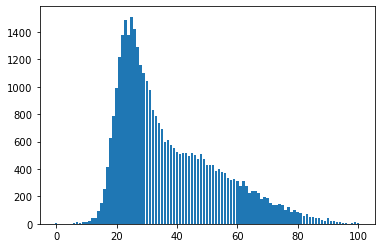

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.bar(np.arange(len(distribution_train)), np.array(distribution_train))
plt.show()

### Distribution in test set

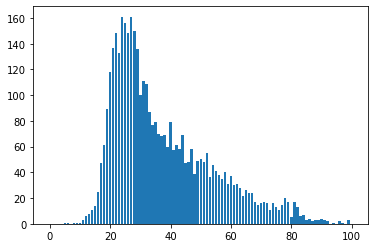

In [12]:
plt.bar(np.arange(len(distribution_test)), np.array(distribution_test))
plt.show()

# Train

### Create DataBlock

In [13]:
from fastai.vision.all import *

def get_parent_as_int(o):
  return int(Path(o).parent.name)

images = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=get_parent_as_int,
    item_tfms=Resize(128)
)

In [14]:
dls = images.dataloaders(path/'train')

### Examples

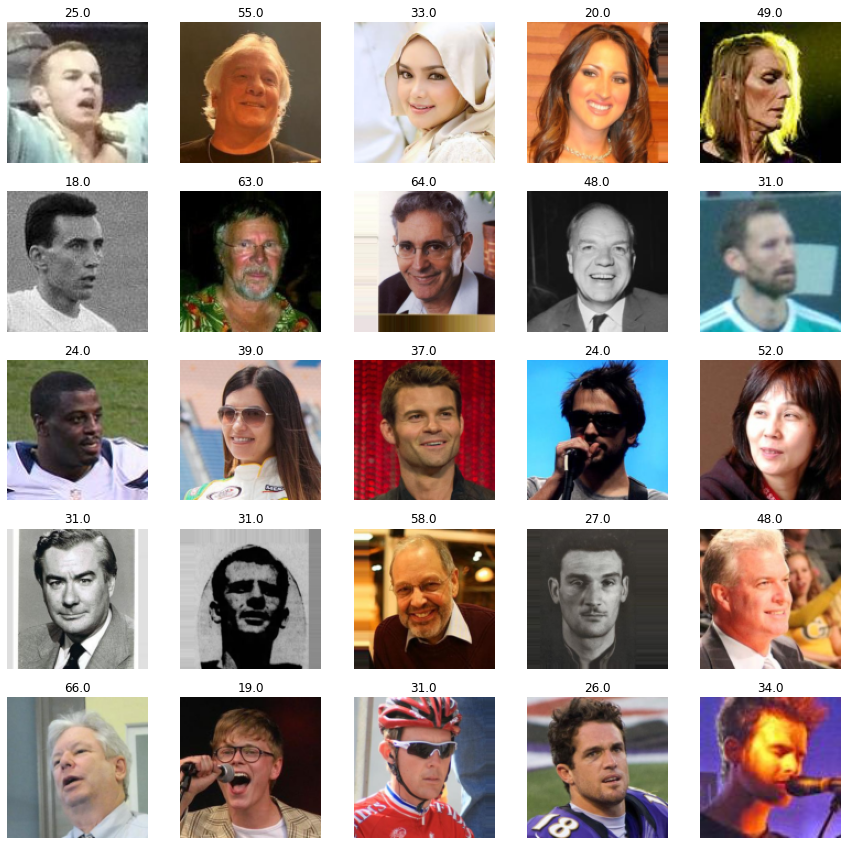

In [15]:
dls.valid.show_batch(max_n=25, nrows=5)

### Learn

In [16]:
learn = vision_learner(dls, resnet18, metrics=mae)
learn.recorder.train_metrics = True
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,train_mae,valid_loss,valid_mae,time
0,308.549286,28.042891,161.529465,9.775212,02:09


epoch,train_loss,train_mae,valid_loss,valid_mae,time
0,149.990143,9.546846,115.816322,8.205368,02:07
1,105.739891,8.082020,98.102493,7.344186,02:07
2,72.313057,6.623025,95.056244,7.148789,02:07
3,47.287277,5.395482,93.228058,7.091848,02:06


Validation mean absolute error not decreasing by much in the last epochs meanwhile train_mae decreases. Training with two epochs to reduce potential overfitting.

In [17]:
learn_2 = vision_learner(dls, resnet18, metrics=mae)
learn_2.recorder.train_metrics = True
learn_2.fine_tune(2)

epoch,train_loss,train_mae,valid_loss,valid_mae,time
0,308.325897,28.029800,166.303696,9.966627,02:03


epoch,train_loss,train_mae,valid_loss,valid_mae,time
0,135.149536,9.443504,105.896072,7.729321,02:07
1,93.607933,7.626707,96.202019,7.388113,02:06


In [19]:
learn_2.export('model.pkl')

# Evaluating

In [22]:
test_images_path = Path('dataset/test')
test_images = get_image_files(test_images_path)

pred_mae = np.array([])

for image in test_images:
    img = Image.open(image)
    with learn_2.no_bar(), learn_2.no_logging():
        pred_data, _, _ = learn_2.predict(image)
    prediction = round(pred_data[0], 1)
    correct_label = int(Path(image).parent.name)
    pred_mae = np.append(pred_mae, abs(prediction - correct_label))

In [23]:
test_mae = np.mean(pred_mae)
print(f'Testset - mean absolute error: {test_mae}')

Testset - mean absolute error: 7.395519044062733


# Gradio

In [ ]:
learn_inf = load_learner('model.pkl')

In [ ]:
#!pip install gradio
import gradio as gr

def image_to_text(image):
    prediction, _, _ = learn_inf.predict(image)
    return round(prediction[0], 1)

inputs = gr.inputs.Image()
output = gr.outputs.Textbox()

interface = gr.Interface(fn=image_to_text, inputs=inputs, outputs=output, title="Image to Text")
interface.launch()